In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
import torch.nn as nn
from sklearn.manifold import TSNE

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


### Read data files and build array

In [3]:
fname = "body_acc_z_train.xlsx"  #the data file is located at the same directory
df=pd.read_excel(fname, header=None)

In [4]:
#convert data to numpy array
numpyX = np.array(df.values)
print(numpyX.shape)

(7352, 128)


### Build input tensor 與 data loader

In [5]:
tensorX = torch.FloatTensor(numpyX)
print(tensorX.shape)

torch.Size([7352, 128])


In [6]:
dataset = Data.TensorDataset(tensorX)

In [7]:
batch_size = 512

In [8]:
dataloader = Data.DataLoader(
    dataset= dataset,     
    batch_size= batch_size,       
    shuffle=True,              
    num_workers=2,             
)

### Define Auto-encoder

Reference: https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder

In [9]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(   
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),                
            nn.Tanh(),
            nn.Linear(64, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 64),                
            nn.Tanh(),
            nn.Linear(64, 128), 
            nn.Tanh(),
            nn.Linear(128, 128), 
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Train NN

In [11]:
num_epochs = 5

In [12]:
train_lossLst = []
for epoch in range(num_epochs):
    if(epoch%100 == 0):
      print(epoch, end=",")
    model.train().to(device)
    train_loss = 0
    epoch_lossLst=[]
    for batchX, in dataloader:
        batchX = batchX.to(device)
        output = model(batchX)
        loss = criterion(output, batchX)
        epoch_lossLst.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg = sum(epoch_lossLst)/len(epoch_lossLst)
    train_lossLst.append(avg) 

0,

### Visualize input and output generated by AE

In [13]:
for batchX, in dataloader:
    break

In [14]:
batchX.shape

torch.Size([512, 128])

In [15]:
output = model(batchX.to(device))

In [16]:
output.shape

torch.Size([512, 128])

In [17]:
output = output.cpu().detach().numpy()

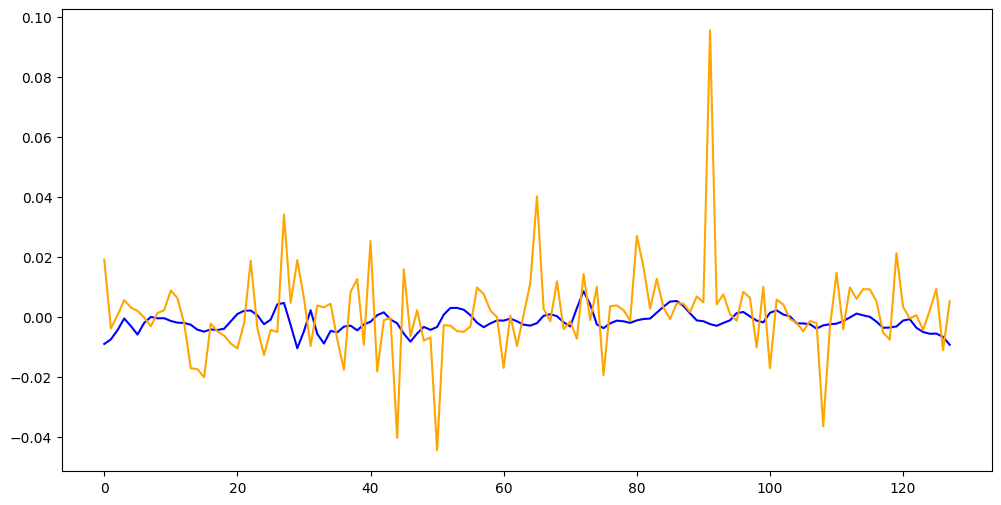

In [18]:
idx = 10  #a number between 0 and batch size-1
fig = plt.figure(figsize=(12, 6))
plt.plot(batchX[0], color='blue')
plt.plot(output[0], color='orange')
plt.show()

### Get the latent vector of the test

In [19]:
fname = "body_acc_z_test.xlsx"  #the data file is located at the same directory
df=pd.read_excel(fname, header=None)

In [20]:
numpyX = np.array(df.values)
tensorX = torch.FloatTensor(numpyX)
print(tensorX.shape)

torch.Size([2947, 128])


In [21]:
output = model.encoder(tensorX.to(device))

In [22]:
output = output.cpu().detach().numpy()
print(output.shape)

(2947, 32)


In [51]:
output.shape[0]

2947

### Clustering and visualization using t-SNE 

In [70]:
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=500)
result = tsne.fit_transform(output)

In [71]:
# get the class labels of the test data 
fname = "y_test.xlsx"  #the data file is located at the same directory
dfY=pd.read_excel(fname, header=None)

In [72]:
lst = dfY.values.tolist()
print(lst)

[[5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [6], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [5], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4], [4],

In [73]:
colors = ['blue', 'green', 'red', 'cyan', 'yellow', 'black', ]  # 6 activities
color_map = []
for elt in dfY.values.tolist():  #1~6
    idx = elt[0]-1
    color_map.append(colors[idx])

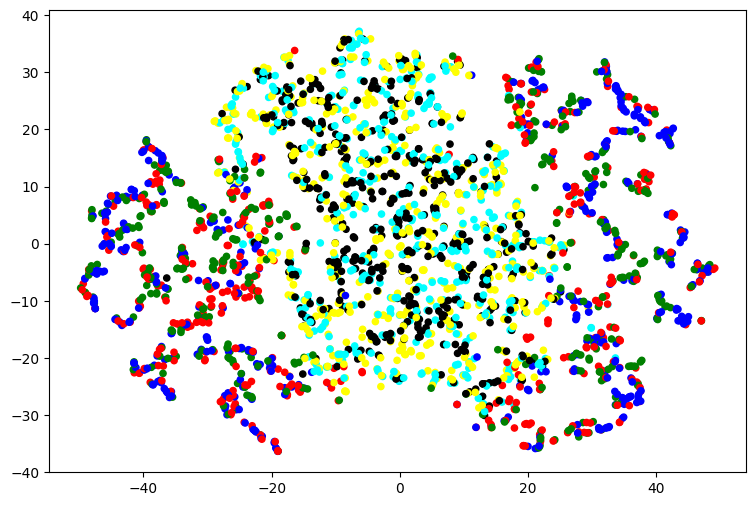

In [74]:
tSNEXarray = result[:, 0]
tSNEYarray = result[:, 1]
fig = plt.figure(figsize=(9, 6))
plt.scatter(tSNEXarray, tSNEYarray, color = color_map, s=20)
plt.show()

### Save clustering results to file

In [77]:
headerLst = ['class', 'x', 'y']
result = []
for idx, elt in enumerate(dfY.values.tolist()):  #1~6
    row = [elt[0], tSNEXarray[idx], tSNEYarray[idx]]
    result.append(row)

In [78]:
df = pd.DataFrame(result, columns = headerLst)
df.to_csv("tSNE_Results.csv", index=False)